In [1]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn
import statsmodels

In [2]:
print("test")

test


# Forecasting

In [10]:
df = pd.read_csv("forecasting_data.csv")

df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interprete the pattern of this time-series

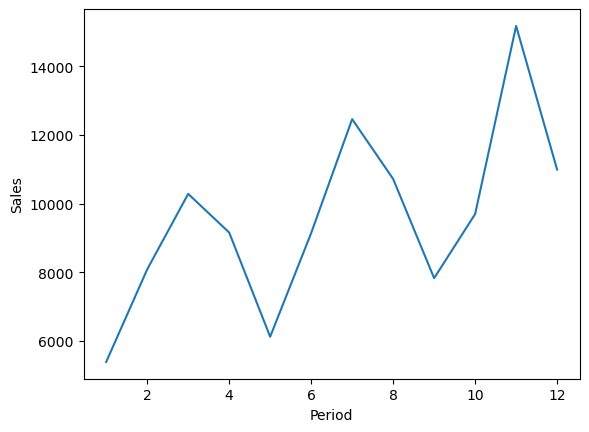

In [11]:
sns.lineplot(data=df, x="Period", y='Sales')
plt.show()

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

In [25]:
# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales']) 
    for m in range(0,to_period):
        if m < k:
            prediction = float("nan")
        else:
            history = df['Sales'][m-k:m] # get past k sales
            prediction = history.mean() # take the mean of the past k sales
        moving_average_df.loc[m] = [m+1, prediction] # set period to be m+1
    moving_average_df['Period'] = moving_average_df['Period'].astype(int)
    return moving_average_df
# pay attention to the gap between when it gets repeated , (period), = 4 months?

ma_df = moving_average(df, 3, 16)
ma_df

,Period,Sales
0,1,NaN
1,2,NaN
2,3,NaN
3,4,7915.666667
4,5,9173.000000
5,6,8518.666667
6,7,8137.666667
7,8,9239.000000
8,9,10772.000000
9,10,10334.000000


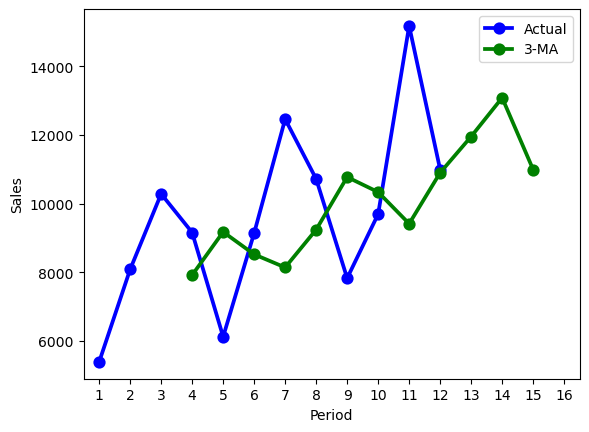

In [26]:
f, ax = plt.subplots(1, 1)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

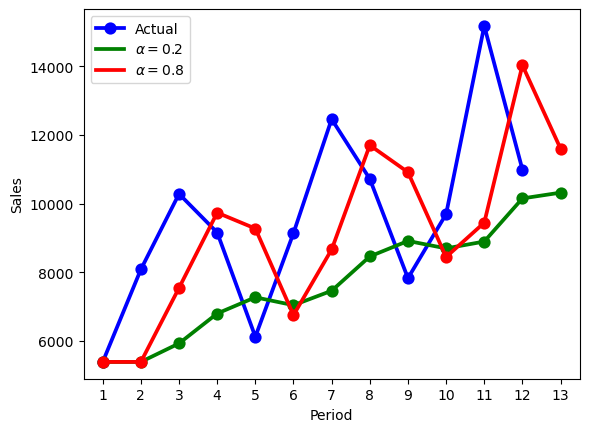

In [27]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
#    es_df["Sales"] = es_df['Sales'].ewm(alpha=alpha, adjust=False).mean()
    es_df.loc[0] = [1, df['Sales'][0]]
    num_df = len(df)
    for m in range(0, num_df):
        prediction = alpha*df['Sales'][m] + (1-alpha)*es_df['Sales'][m]
        es_df.loc[m+1] = [m+2, prediction]
    es_df['Period'] = es_df['Period'].astype(int)
    return es_df

f, ax = plt.subplots(1, 1)
# lower alpha = pays less attention to current trend/data
es_df_02 = exponential_smoothing(df, 0.2)
# once you increase alpha a bit it is better suited to react to the data
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality

C:\Users\Madi\AppData\Local\Temp\ipykernel_11504\2215574431.py:33: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(season, avg_arr, 3)


    Period         Sales
12      13   8056.975955
13      14  11320.795659
14      15  15796.608425
15      16  12980.851183


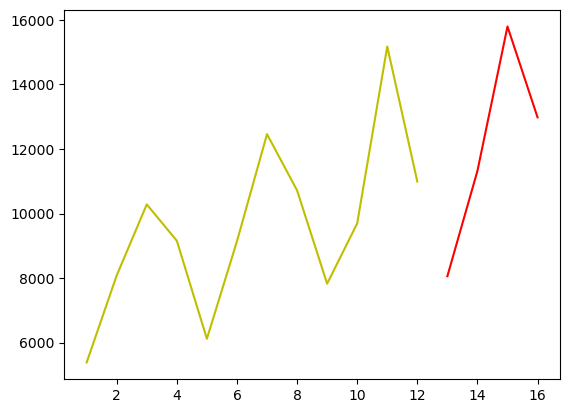

In [65]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    season_df = pd.DataFrame((new_df.pivot(index='Seq',columns='Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)
    
    avg_df = season_df.apply(np.mean) 
    
    # calc seasonal index based off averages
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = season_df['I']/avg_df['I']
    seasonal_index_df['II'] = season_df['II']/avg_df['II']
    seasonal_index_df['III'] = season_df['III']/avg_df['III']
    seasonal_index_df['Avg'] = seasonal_index_df.mean(axis=1)
    
    # 3 seasons, 4 omonths per season ?
    # linear regression interpolating what datas gna look like up the trendline
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    
    # predict sales. avergage_perdict = prediction for next yr
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Sales'] = seasonal_index_df['Avg']*average_predict
    forecast_df['Period'] = months
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])
print(season_df)

# the result uses seasonality ot predict the values for the next period from month 13-16 ?? idk.
f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

# 4.Evaluation: compare the above implemented methods

In [66]:
print(df)

    Period  Sales
0        1   5384
1        2   8081
2        3  10282
3        4   9156
4        5   6118
5        6   9139
6        7  12460
7        8  10717
8        9   7825
9       10   9693
10      11  15177
11      12  10990


In [82]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)
eval_df

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118
5,6,9139
6,7,12460
7,8,10717
8,9,7825
9,10,9693


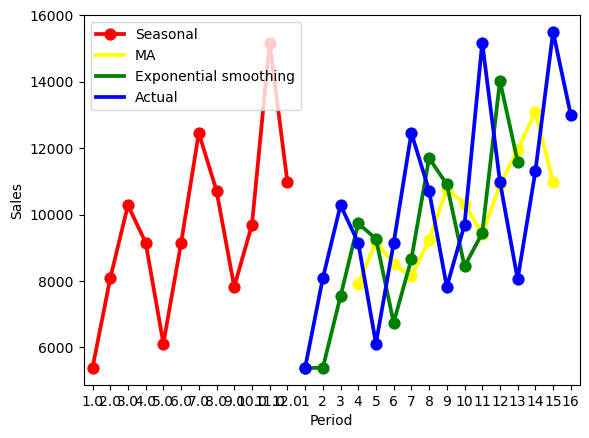

In [83]:
f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()

In [98]:
MAD = np.absolute(eval_df['Sales'][12:16] - moving_average(eval_df, 3, 16)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.2)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = np.absolute(eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.8)['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))


MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2707.7580143305513
MAD of Exponential smoothing with alpha=0.8: 3088.7232615120074


for some reason it wont let me run this part !!

In [97]:
season_df = predict_with_seasonality(eval_df, [13,14,15,16])
MAD = np.absolute(eval_df['Sales'][12:16] - season_df['Sales'][12:16]).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

ValueError: Index contains duplicate entries, cannot reshape

In [102]:
MSE = (eval_df['Sales'][12:16] - moving_average(eval_df, 3, 16)['Sales'][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE = ((eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.2)['Sales'][12:16])**2).mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
MSE = ((eval_df['Sales'][12:16] - exponential_smoothing(eval_df, 0.8)['Sales'][12:16])**2).mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))


MSE of 3-MA: 11544241.36111111
MSE of Exponential smoothing with alpha=0.2: 9744054.271861337
MSE of Exponential smoothing with alpha=0.8: 10909182.694821384
MSE of Seasonality Method: Ellipsis


same as above, this wont let me run

In [103]:
season_df = predict_with_seasonality(eval_df, [13, 14, 15, 16])
MSE = ( (eval_df['Sales'][12:16] - season_df['Sales'][12:16])**2).mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

ValueError: Index contains duplicate entries, cannot reshape